<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Hybrid%20RF-RNN%20for%204%20class%20classifications%20based%20on%20WSN-DS%20dataset_rev.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Hybrid RF-RNN for 4 class classifications based on WSN-DS dataset**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load dataset
dataset = pd.read_csv("dataset.csv")
dataset.isnull().sum()

Event             0
Time              0
S_Node            0
Node_id           0
Rest_Energy       0
Trace_Level       0
Mac_Type_Pckt     0
Source_IP_Port    0
Des_IP_Port       0
Packet_Size       0
TTL               0
Hop_Count         0
Broadcast_ID      0
Dest_Node_Num     0
Dest_Seq_Num      0
Src_Node_ID       0
Src_Seq_Num       0
Class             0
dtype: int64

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312106 entries, 0 to 312105
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Event           312106 non-null  int64  
 1   Time            312106 non-null  float64
 2   S_Node          312106 non-null  int64  
 3   Node_id         312106 non-null  int64  
 4   Rest_Energy     312106 non-null  float64
 5   Trace_Level     312106 non-null  int64  
 6   Mac_Type_Pckt   312106 non-null  int64  
 7   Source_IP_Port  312106 non-null  float64
 8   Des_IP_Port     312106 non-null  float64
 9   Packet_Size     312106 non-null  int64  
 10  TTL             312106 non-null  int64  
 11  Hop_Count       312106 non-null  int64  
 12  Broadcast_ID    312106 non-null  int64  
 13  Dest_Node_Num   312106 non-null  int64  
 14  Dest_Seq_Num    312106 non-null  int64  
 15  Src_Node_ID     312106 non-null  int64  
 16  Src_Seq_Num     312106 non-null  int64  
 17  Class     

In [4]:
dataset["Class"].unique()

array([0, 1, 2, 3])

In [5]:
# Data preprocessing
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
y = np_utils.to_categorical(y, num_classes=4)
X = dataset.drop(['Class'],axis=1)
X=X.values
print(X.shape)
print(y.shape)

(312106, 17)
(312106, 4)


In [6]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### **Hybrid combination of RF-RNN for 4 class classifications**

In [8]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

from keras.layers import SimpleRNN

# RNN model
model = Sequential()
model.add(SimpleRNN(64, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

history = model.fit(X_train_rnn, y_train, epochs=10, batch_size=64, validation_data=(X_test_rnn, y_test), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
13143/13143 [==============================] - 96s 7ms/step - loss: 0.6347 - accuracy: 0.7071 - val_loss: 0.4991 - val_accuracy: 0.7794
Epoch 2/10
13143/13143 [==============================] - 93s 7ms/step - loss: 0.4936 - accuracy: 0.7841 - val_loss: 0.4184 - val_accuracy: 0.8204
Epoch 3/10
13143/13143 [

In [9]:
# Combine models
y_pred_rnn = model.predict(X_test_rnn)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
y_pred_rnn = np_utils.to_categorical(y_pred_rnn, num_classes=4)

y_pred = y_pred_rnn * 0.5 + y_pred_rf * 0.5
y_pred = np.argmax(y_pred, axis=1)

# Evaluation metrics
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Accuracy:", accuracy)

6572/6572 [==============================] - 19s 3ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     52500
           1       1.00      0.88      0.93     52554
           2       1.00      0.97      0.98     52545
           3       1.00      1.00      1.00     52682

    accuracy                           0.96    210281
   macro avg       0.97      0.96      0.96    210281
weighted avg       0.97      0.96      0.96    210281

[[52495     2     3     0]
 [ 6425 46124     0     5]
 [ 1726    26 50786     7]
 [    0    14     7 52661]]
Accuracy: 0.9609332274432782


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  plt.figure(figsize=(6,5.5))
  ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='YlGnBu')
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-RNN Model


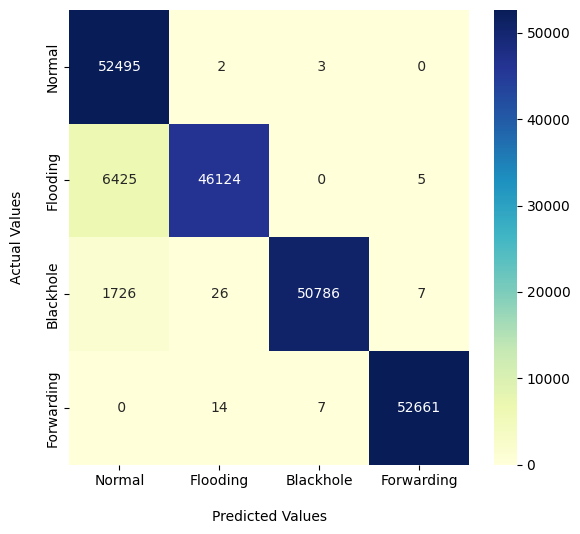

In [11]:
print("Confusion Matrix of Hybrid RF-RNN Model") 
conf_mat(np.argmax(y_test, axis=1), y_pred)

In [12]:
report = classification_report(np.argmax(y_test, axis=1), y_pred, output_dict=True)
detection_rates = {}
for cls in range(4):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']
print("Detection rates:", detection_rates)

Detection rates: {0: 0.9999047619047619, 1: 0.8776496555923431, 2: 0.9665239318679227, 3: 0.9996013818761627}
